<a href="https://colab.research.google.com/github/tangQAQ/LSTM_training/blob/main/Kinder%20suprise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import numpy
class data_process:
  def __init__(self):
    pass

  def split_sequences(self, data, slice_size, sequences):
    size = int(len(data) * slice_size)
    train = data[:size]
    val = data[size:]

    X_train, y_train = self.create_sequences(train, sequences)
    X_val, y_val = self.create_sequences(val, sequences)
    return X_train, y_train, X_val, y_val 

  def create_sequences(self, data, sequences):
    X = []
    y = []
    for i in range(sequences, len(data)):
        X.append(data.iloc[i-sequences:i, :])
        y.append(data.iloc[i, :])
    X = numpy.array(X)
    y = numpy.array(y)
    return X, y

In [15]:
import pandas

class read_process:
  def __init__(self):
    pass
  
  def read_process(self, data):
    data = data.drop(['Date'], axis=1)
    data = data.apply(lambda x: pd.to_numeric(x.str.replace(',',''), errors='coerce')).fillna(-1).astype('float32')
    return data
  
  def feature(self, data):
    data['Pct_change'] = data['Close'].pct_change()
    data.drop(data.index[0], inplace=True)
    data['feature_check'] = data['Pct_change'].round(2)*100
    data['feature'] = data['feature_check'].apply(self.replace_values)
    return data

  def replace_values(self, x):
    if x < -10:
      return -11
    elif x > 10:
      return 11
    elif x >= 0 and x <=1 :
      return 1
    elif x < 0 and x >= -1:
      return -1
    else:
      return x

In [38]:
import matplotlib.pyplot as plt

class Model_patten:
  def __init__(self, X_train, y_train, X_val, y_val):
        self.model = Sequential()
        self.model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
        self.model.add(LSTM(units=64, return_sequences=False))
        self.model.add(Dense(units=X_train.shape[2], activation='softmax'))
        self.model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics='accuracy')
        self.history = self.model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=2, batch_size=32)

  def get_loss(self):
    plt.plot(self.history.history['loss'])
    plt.plot(self.history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

  def get_acc(self):
    plt.plot(self.history.history['accuracy'])
    plt.plot(self.history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
 
  def predict(self, X_test):
    return self.model.predict(X_test)

In [93]:
from sklearn.preprocessing import OneHotEncoder
import numpy
import pandas

class OHEncoder:
  def __init__(self):
    self.enc = None

  def Encoder(self, data):
    data_copy = data.copy()
    enc = OneHotEncoder(sparse=False)
    one_hot = enc.fit_transform(data_copy.values.reshape(-1, 1))
    one_hot_df = pandas.DataFrame(one_hot)
    self.enc = enc
    return one_hot_df

  def transform(self, data):
    transform = self.enc.transform(data.values.reshape(-1, 1))
    tr = pandas.DataFrame(transform)
    return tr

  def Decoder(self, data):
    data_dec = numpy.eye(data.shape[1])[data.argmax(axis=1)]
    return self.enc.inverse_transform(data_dec)

In [99]:
import matplotlib.pyplot as plt

class PlotGraph:
    def __init__(self):
        pass
    
    def predict_graph(self, result, actual, timestep):
        plt.figure(figsize=(12, 8))
        plt.title(f'Actual vs. Predicted Pct_change Prices(Timestep {timestep})')
        plt.xlabel('Time line')
        plt.ylabel('Pct_change')
        plt.plot(result, label='Predicted Feature', color='b', linestyle='--')
        plt.plot(actual, label='Actual Feature', color='r')
        plt.ylim([-12, 12])
        plt.legend()
        plt.show()

In [96]:
import pandas as pd
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, TimeDistributed
from keras.callbacks import EarlyStopping
from google.colab import drive
import matplotlib.pyplot as plt
from keras.optimizers import Adam
import warnings 

warnings.filterwarnings('ignore')

drive.mount('/content/gdrive')
train_data = pd.read_csv("/content/gdrive/MyDrive/GSPC_train.csv")
test_df = pd.read_csv("/content/gdrive/MyDrive/GSPC_test.csv")
Actual_data = pd.read_csv("/content/gdrive/MyDrive/GSPC_Actual.csv")
total = pd.concat((train_data, test_df), axis=0)

rp = read_process()
train = rp.read_process(total)
train_feature = rp.feature(train)
A_d = rp.read_process(Actual_data)
Actual_feature = rp.feature(A_d)

enc_7 = OHEncoder()
enc_15 = OHEncoder()
enc_30 = OHEncoder()

ohe_7 = enc_7.Encoder(train_feature['feature'])
ohe_15 = enc_15.Encoder(train_feature['feature'])
ohe_30 = enc_30.Encoder(train_feature['feature'])

dp = data_process()
X_train_7, y_train_7, X_val_7, y_val_7 = dp.split_sequences(ohe_7, 0.8, 7)
X_train_15, y_train_15, X_val_15, y_val_15 = dp.split_sequences(ohe_15, 0.8, 15)
X_train_30, y_train_30, X_val_30, y_val_30 = dp.split_sequences(ohe_30, 0.8, 30)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Epoch 1/2
599/599 [==============================] - 16s 20ms/step - loss: 1.0360 - accuracy: 0.6974 - val_loss: 0.9560 - val_accuracy: 0.7092
Epoch 2/2
599/599 [==============================] - 10s 17ms/step - loss: 0.9661 - accuracy: 0.7005 - val_loss: 0.9524 - val_accuracy: 0.7090


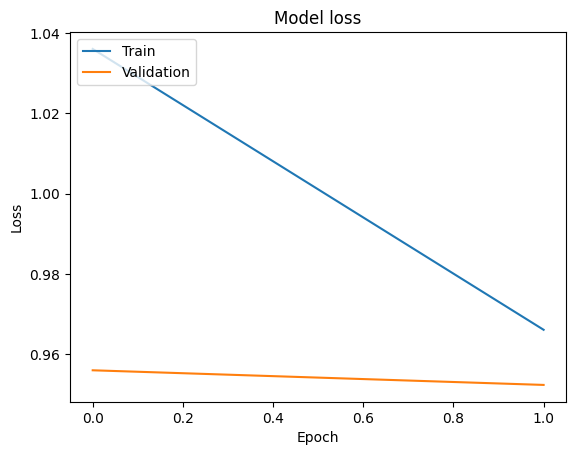

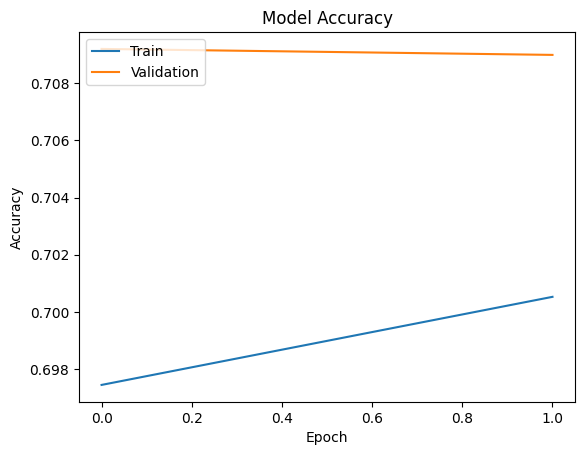

In [40]:
model_7 = Model_patten(X_train_7, y_train_7, X_val_7, y_val_7)
model_7.get_loss()
model_7.get_acc()

Epoch 1/2
598/598 [==============================] - 30s 42ms/step - loss: 1.0236 - accuracy: 0.6994 - val_loss: 0.9624 - val_accuracy: 0.7089
Epoch 2/2
598/598 [==============================] - 21s 35ms/step - loss: 0.9571 - accuracy: 0.7004 - val_loss: 0.9542 - val_accuracy: 0.7085


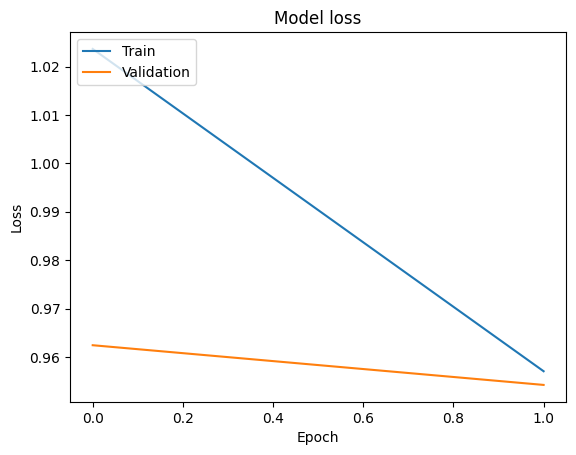

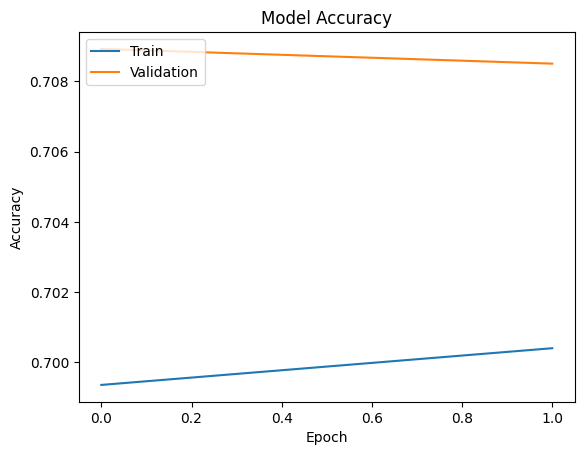

In [41]:
model_15 = Model_patten(X_train_15, y_train_15, X_val_15, y_val_15)
model_15.get_loss()
model_15.get_acc()

Epoch 1/2
598/598 [==============================] - 34s 50ms/step - loss: 1.0179 - accuracy: 0.6993 - val_loss: 0.9748 - val_accuracy: 0.7095
Epoch 2/2
598/598 [==============================] - 29s 48ms/step - loss: 0.9524 - accuracy: 0.7004 - val_loss: 0.9570 - val_accuracy: 0.7095


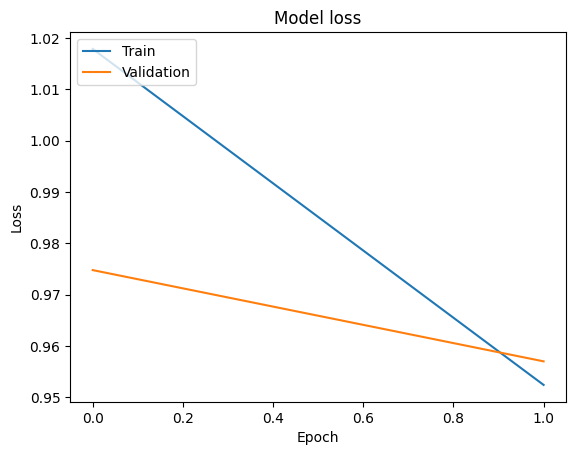

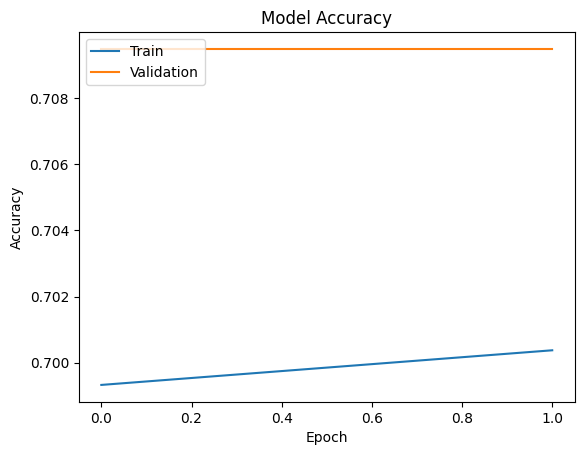

In [42]:
model_30 = Model_patten(X_train_30, y_train_30, X_val_30, y_val_30)
model_30.get_loss()
model_30.get_acc()

In [ ]:
test_data_7 = pd.read_csv("/content/gdrive/MyDrive/GSPC_test_7.csv")
test_data_15 = pd.read_csv("/content/gdrive/MyDrive/GSPC_test_15.csv")
test_data_30 = pd.read_csv("/content/gdrive/MyDrive/GSPC_test_30.csv")

test_d7 = rp.read_process(test_data_7)
test_d15 = rp.read_process(test_data_15)
test_d30 = rp.read_process(test_data_30)

test_7 = rp.feature(test_d7)
test_15 = rp.feature(test_d15)
test_30 = rp.feature(test_d30)



In [104]:
test_enc_7 = enc_7.transform(test_7['feature'])
test_enc_15 = enc_15.transform(test_15['feature'])
test_enc_30 = enc_30.transform(test_30['feature'])

X_test_7, y_test_7 = dp.create_sequences(test_enc_7, 7)
X_test_15, y_test_15 = dp.create_sequences(test_enc_15, 15)
X_test_30, y_test_30 = dp.create_sequences(test_enc_30, 30)

test_pred_7 = model_7.predict(X_test_7)
test_pred_15 = model_15.predict(X_test_15)
test_pred_30 = model_30.predict(X_test_30)

inverse_7 = enc_7.Decoder(test_pred_7)
inverse_15 = enc_15.Decoder(test_pred_15)
inverse_30 = enc_30.Decoder(test_pred_30)

1/1 [==============================] - 1s 910ms/step


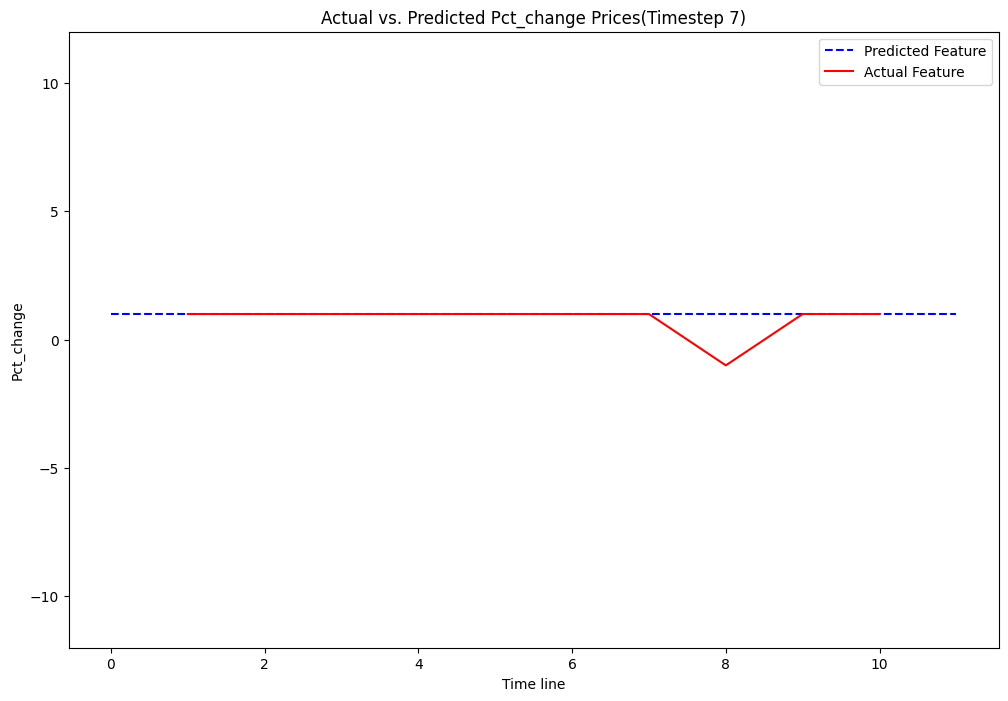

In [105]:
pg = PlotGraph()
pg.predict_graph(inverse_7, Actual_feature['feature'], 7)

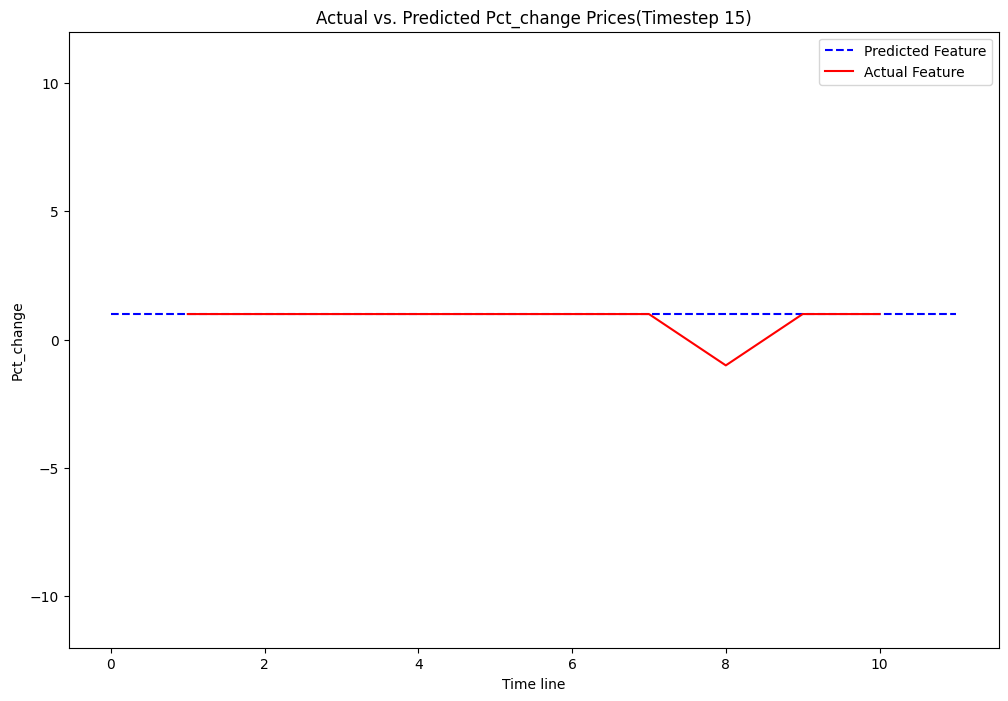

In [106]:
pg.predict_graph(inverse_15, Actual_feature['feature'], 15)

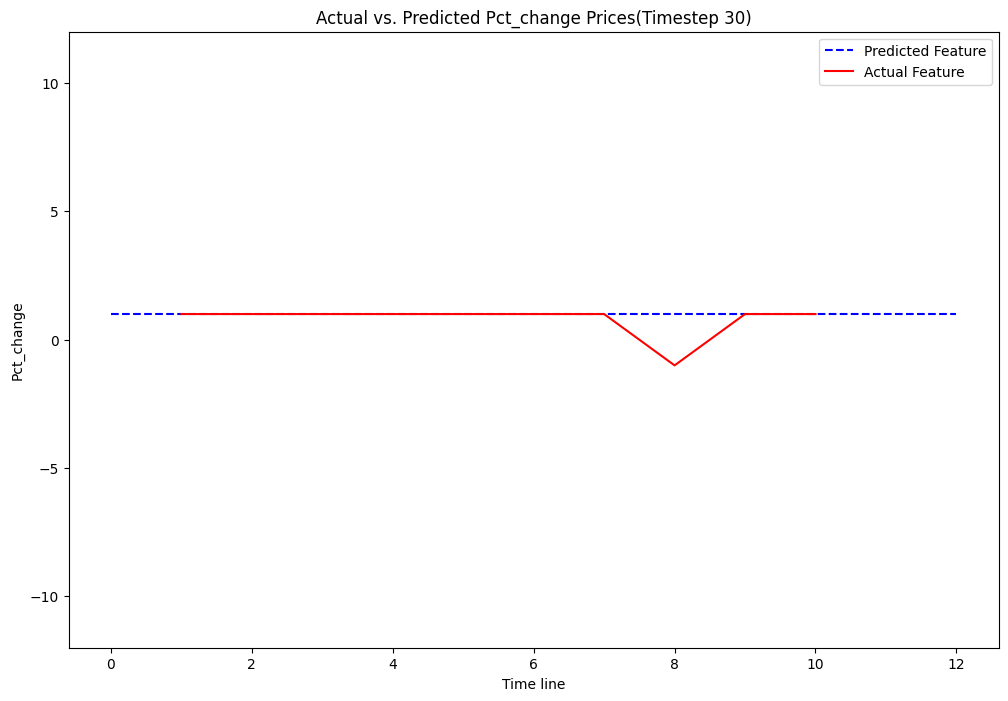

In [107]:
pg.predict_graph(inverse_30, Actual_feature['feature'], 30)